In [32]:
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests

In [3]:
# setup file system
os.makedirs('data', exist_ok=True)

In [12]:
# current nfl state
state = requests.get('https://api.sleeper.app/v1/state/nfl').json()
state

{'week': 7,
 'season_type': 'regular',
 'season_start_date': '2022-09-08',
 'season': '2022',
 'previous_season': '2021',
 'leg': 7,
 'league_season': '2022',
 'league_create_season': '2022',
 'display_week': 7}

In [4]:
# get players
players = requests.get('https://api.sleeper.app/v1/players/nfl').json()

with open('data/players.json', 'w') as f:
    json.dump(players, f, indent=4)

In [2]:
# process players file
players_df = pd.read_json('data/players.json').transpose()[['first_name', 'last_name', 'position', 'team', 'status', 'injury_status', 'active', 'player_id']]

# filter players
players_df = players_df[players_df['position'].isin(['QB', 'RB', 'WR', 'TE', 'K', 'DEF'])]
players_df = players_df[players_df['active']]
players_df = players_df[players_df['team'].notna()]

# project players
players_df['name'] = players_df['first_name'] + " " + players_df['last_name']
players_df = players_df[['name', 'position', 'team', 'status', 'injury_status', 'player_id']]
players_df.head()

,name,position,team,status,injury_status,player_id
5870,Daniel Jones,QB,NYG,Active,None,5870
8595,Kyric McGowan,WR,WAS,Active,None,8595
3199,Michael Thomas,WR,NO,Inactive,Out,3199
8209,Makai Polk,WR,NYG,Active,None,8209
5781,Malik Turner,WR,SF,Active,None,5781


In [6]:
# player weekly stats for 2022
def get_weekly_stats(season, num_weeks):
    season_stats = []
    for week in range(1, num_weeks + 1):
        weekly = requests.get(f'https://api.sleeper.com/stats/nfl/{season}/{week}?season_type=regular&position[]=DEF&position[]=K&position[]=QB&position[]=RB&position[]=TE&position[]=WR').json()
        season_stats.extend(weekly) 
    return season_stats

season = 2022
weeks = 6
season_stats = get_weekly_stats(season, weeks)
with open(f'data/weekly-{season}.json', 'w') as f:
    json.dump(season_stats, f, indent=4)

In [4]:
# load season weekly stats
with open(f'data/weekly-{season}.json') as f:
    weekly = json.load(f)

weekly_df = pd.json_normalize(weekly).drop(columns=[
    'team', 'sport', 'season_type', 'company', 'category', 'game_id', 'date',
    'player.years_exp', 'player.news_updated', 'player.metadata', 'player.injury_status', 'player.injury_start_date', 'player.injury_notes', 'player.injury_body_part', 'player.fantasy_positions'
])
weekly_df.head()

,week,season,player_id,opponent,last_modified,stats.tm_st_snp,stats.tm_off_snp,stats.tm_def_snp,stats.gms_active,stats.adp_dd_ppr,...,stats.pts_idp,stats.idp_ff,stats.idp_tkl_ast,stats.tkl_solo_misc,stats.ff_misc,stats.yds_allow_550p,player.metadata.years_exp_shift,stats.st_ff,stats.idp_tkl_loss,stats.idp_safe
0,1,2022,1029,HOU,NaN,24.0,92.0,70.0,1.0,999.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2022,1034,LAC,NaN,21.0,58.0,67.0,1.0,999.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2022,1049,NYG,NaN,23.0,65.0,60.0,1.0,999.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2022,1067,WAS,NaN,17.0,70.0,77.0,1.0,999.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2022,1099,NYG,NaN,23.0,65.0,60.0,1.0,999.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# get projected weekly stats for 2022
def get_projected_weekly_stats(season, num_weeks):
    season_stats = []
    for week in range(1, num_weeks + 1):
        weekly = requests.get(f'https://api.sleeper.com/projections/nfl/{season}/{week}?season_type=regular&position[]=DEF&position[]=K&position[]=QB&position[]=RB&position[]=TE&position[]=WR').json()
        season_stats.extend(weekly) 
    return season_stats

season_stats = get_projected_weekly_stats(season, weeks + 1)
with open(f'data/projected-weekly-{season}.json', 'w') as f:
    json.dump(season_stats, f, indent=4)

In [5]:
# load season projected weekly stats
with open(f'data/projected-weekly-{season}.json') as f:
    weekly = json.load(f)

# remove player object from stats
for stat in weekly:
    del stat['player']

proj_df = pd.json_normalize(weekly).drop(columns=[
    'team', 'sport', 'season_type', 'company', 'category', 'game_id', 'date', 'last_modified'
])
proj_df.head()

,week,season,player_id,opponent,stats.rush_yd,stats.rush_td,stats.rush_fd,stats.rush_att,stats.rec_yd,stats.rec_tgt,...,stats.blk_kick,stats.yds_allow_350_399,stats.pts_allow_21_27,stats.pts_allow_14_20,stats.st_td,stats.def_pr_td,stats.blk_kick_ret_td,stats.yds_allow_300_349,stats.safe,stats.yds_allow_200_299
0,1,2022,1034,LAC,7.70,0.03,0.77,1.8,5.95,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2022,1049,NYG,15.87,0.15,1.59,3.2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2022,1067,WAS,NaN,NaN,NaN,NaN,41.04,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2022,1099,NYG,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2022,111,MIN,NaN,NaN,NaN,NaN,11.85,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Question: who are the top 10 tight ends this season?

# get all tight ends
te_df = players_df[players_df['position'] == 'TE']

# weekly stats for all tight ends
te_weekly = weekly_df.join(te_df, on='player_id', rsuffix='1', how='inner')

# summarize points by player
te_season = te_weekly[['player_id', 'stats.pts_std']].groupby('player_id').sum(numeric_only=True)

# top 10 TEs by points
top_tes = te_season.sort_values(by='stats.pts_std', ascending=False)[:10]

# Answer:
players_df.join(top_tes, how='inner').sort_values(by='stats.pts_std', ascending=False)

,name,position,team,status,injury_status,player_id,stats.pts_std
1466,Travis Kelce,TE,KC,Active,None,1466,90.00
5012,Mark Andrews,TE,BAL,Active,Questionable,5012,75.80
4381,Taysom Hill,TE,NO,Active,None,4381,62.42
5844,T.J. Hockenson,TE,DET,Active,None,5844,46.70
1339,Zach Ertz,TE,ARI,Active,None,1339,43.90
5022,Dallas Goedert,TE,PHI,Active,None,5022,41.70
4033,David Njoku,TE,CLE,Active,None,4033,38.10
4089,Gerald Everett,TE,LAC,Active,Questionable,4089,36.20
4993,Mike Gesicki,TE,MIA,Active,None,4993,35.00
5010,Will Dissly,TE,SEA,Active,None,5010,32.90


<AxesSubplot: xlabel='week'>

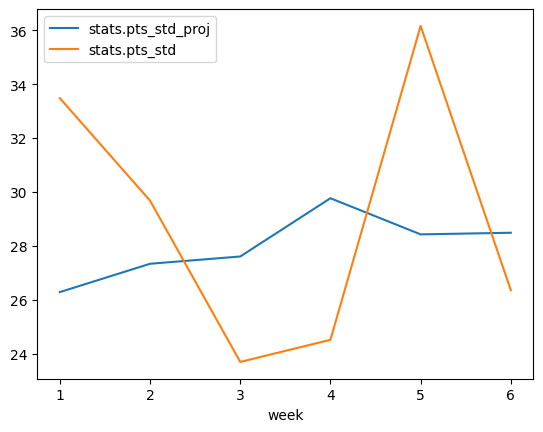

In [31]:
# Question: How is a player doing compared to their projected?

player = players_df[players_df['name'] == 'Josh Allen']
player_stats = weekly_df.join(player, on='player_id', rsuffix='1', how='inner')[['player_id', 'stats.pts_std', 'week']]
player_proj = proj_df.join(player, on='player_id', rsuffix='1', how='inner')[['player_id', 'stats.pts_std', 'week']]
stats = player_proj.join(player_stats.set_index('week'), on='week', lsuffix='_proj', how='left')[['week', 'stats.pts_std_proj', 'stats.pts_std']]
stats.plot(x='week', y=['stats.pts_std_proj', 'stats.pts_std'])